In [31]:
# /**
#  * @author [Zhongya]
#  * @email [zhongya66@whu.edu.cn]
#  * @create date 2024-09-25 04:58:32
#  * @modify date 2024-09-25 04:58:32
#  * @desc AE_joint_PS_GS_model_free_r1
#  *       1. use tf.GradientTape() to calculate the gradients
#  *       2. use GMI to optimize BITs to constellation mapping and PS
#  *       3. use pre-trained bit-to-symbol mapper to initialize the training process
#  *       4. use the real channel impairments to train the model
#  *       5. Use a receiver side equalizer to estimate the channel and include the channel information in the equalizer,
#  *        so that realizing a model-free method
#  *       6. Use the GMI as the loss function, remove receiver side NN decoder
#  */

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D
from helper_lite import p_norm, log2, dB2lin, GMIcal_tf, _encoder, GMIcal, Complex_Layer, zeroUpsampling
import matplotlib.colors as colors
import time
import os
from scipy import signal

# %%
print('Tensorflow version:', tf.__version__)
print('Tensorflow probability version:', tfp.__version__)
seed = 45
tf.compat.v1.set_random_seed(seed)
np.random.seed(seed)

# %%
# Parameters
# Channel Parameters
M              = 64
channel_SNR_db = 10
bitlen         = int(np.log2(M))

# Auto-Encoder Parameters
constellationDim   = 2
constellationOrder = M
temperature        = 1
nLayersEnc         = 1
nLayersDec         = 2
nHiddenEnc         = 128
nHiddenDec         = 128
activation         = tf.nn.relu
dtype              = tf.float32
cpx_dtype          = tf.complex64

# Training Parameters
nBatches      = 16
batchSize     = 16384
learningRate  = 0.001
displayStep   = 10
iterations    = 200

Retrain_flag = 0
Eq_retrain   = 0
eq_flag      = 1
GS_flag      = (1,)*1+(1,)*2
PS_flag      = (1,)*1+(1,)*2
norm_epsilon = 1e-12

NGMI_th = 0.86
shaping_filter_len = 55

# Channel Parameters
nl_factor       = 0.5
Fs              = 6
channel_type    = 'ISI_NL'

Tensorflow version: 2.3.0
Tensorflow probability version: 0.11.1


## Define the used functions

In [32]:
# TF constants
one = tf.constant(1, dtype)
twoZeroCpx = tf.constant(2, cpx_dtype)

# %%
def r2c(x):
    return tf.cast(x, cpx_dtype)

def c2r(x):
    return tf.cast(x, dtype)

@tf.custom_gradient
def straight_through_estimator(s_bar):
    s = tf.one_hot(tf.math.argmax(s_bar, axis=-1), M)
    def grad(dy):
        return dy
    return s, grad

@tf.custom_gradient
def hard_decision_on_bit(soft_bits):
    hard_bits = (tf.sign(soft_bits-0.5)+1)/2
    def grad(dy):
        return dy
    return hard_bits, grad

def upsample_pulse_shaping(x, upsample_rate, pulse_shape):
    x = tf.cast(x, cpx_dtype)
    x = tf.reshape(x, (1, -1, 1))
    x_up = zeroUpsampling(upsample_rate)(x)
    x_up_real = tf.math.real(x_up)
    x_up_imag = tf.math.imag(x_up)
    
    pulse_shape_real = pulse_shape[0]
    pulse_shape_imag = pulse_shape[1]
    x_up_RRC_real = tf.nn.conv1d(x_up_real, pulse_shape_real, stride=1, padding='SAME')
    x_up_RRC_imag = tf.nn.conv1d(x_up_imag, pulse_shape_imag, stride=1, padding='SAME')
    x_up_RRC = x_up_RRC_real + x_up_RRC_imag
    x_up_RRC = tf.squeeze(x_up_RRC) 
    return x_up_RRC

def phase_noise_estimation(x, y):
    phase_noise = tf.reduce_mean(tf.math.angle(tf.math.conj(x)*y))
    y_phase_corrected = y*tf.math.exp(-1j*r2c(phase_noise))
    return y_phase_corrected

## Pre-train a one-hot to bits mapper

In [33]:
# 0. pre-train a one-hot to bits mapper
## generating the training data
symbol_set = tf.range(0,constellationOrder)
onehot_set = tf.one_hot(symbol_set,depth=M,dtype=dtype)
bit_set    = tf.math.mod(tf.bitwise.right_shift(tf.expand_dims(symbol_set,1), tf.range(bitlen)), 2)
bit_set    = tf.reverse(bit_set, axis = [-1])


## define the mapper
if os.path.isfile('./models/soft_bit_encoder_'+str(bitlen)+'bits.hdf5'):
    print('[INFO] Load existing model named'+'./models/soft_bit_encoder_'+str(bitlen)+'bits.hdf5')
    soft_bit_encoder = tf.keras.models.load_model('./models/soft_bit_encoder_'+str(bitlen)+'bits.hdf5')
else:
    onehot_input     = Input(shape = (M,),name='onehot_input')
    soft_bits_vec    = _encoder(onehot_input, nHiddenDec, nLayersDec, tf.nn.sigmoid, nOutput=bitlen, name='bit_encoder')
    soft_bit_encoder = Model(inputs = [onehot_input], outputs = [soft_bits_vec], name = 'soft_bit_encoder')
    soft_bit_encoder.compile(optimizer='adam',loss='mse')
    
    ## generating the training data
    symbol_set = tf.range(0,constellationOrder)
    onehot_set = tf.one_hot(symbol_set,depth=M,dtype=dtype)
    bit_set    = tf.math.mod(tf.bitwise.right_shift(tf.expand_dims(symbol_set,1), tf.range(bitlen)), 2)
    bit_set    = tf.reverse(bit_set, axis = [-1])
    
    Loss = soft_bit_encoder.fit(onehot_set,bit_set,epochs=2000,verbose=0)
    tf.keras.models.save_model(soft_bit_encoder,filepath='./models/soft_bit_encoder_'+str(bitlen)+'bits.hdf5')
    print('[INFO] Save new trained model named'+'./models/soft_bit_encoder_'+str(bitlen)+'bits.hdf5')
    
    soft_bits_out = soft_bit_encoder(onehot_set[0:64])
    hard_bits_out = ((tf.sign(soft_bits_out-0.5)+1)/2).numpy()
    print('[DEBUG] hard bits = %e\n'%(Loss.history['loss'][-1]),'hard bits = \n', hard_bits_out)

soft_bits_out = soft_bit_encoder(onehot_set[0:64])
hard_bits_out = ((tf.sign(soft_bits_out-0.5)+1)/2).numpy()
    
soft_bit_encoder.trainable = False

[INFO] Load existing model named./models/soft_bit_encoder_6bits.hdf5


## load FIR channel

C:\Users\Zhongya\AppData\Local\Temp/ipykernel_33516/134355267.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig4.show()


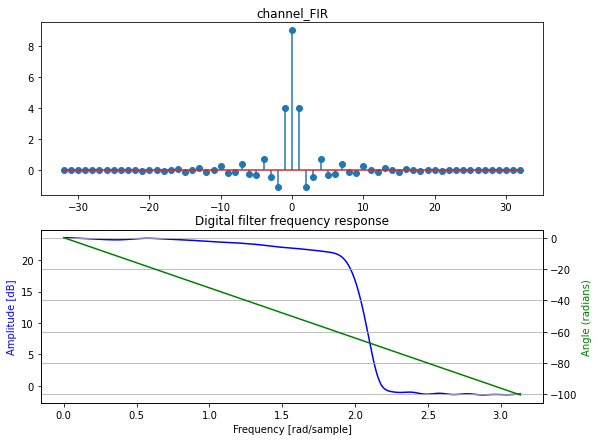

In [34]:
channel_FIR = np.flip(np.loadtxt('W_t_btb.txt'))
filter_len = channel_FIR.shape[0]

## visualization
fig4, ax4 = plt.subplots(2,1)
fig4.set_size_inches(9,7)
x = np.linspace(-filter_len/2+1/2, filter_len/2-1/2, filter_len)
ax4[0].stem(x,channel_FIR.squeeze())
ax4[0].title.set_text('channel_FIR')

w, h = signal.freqz(channel_FIR)
ax4[1].set_title('Digital filter frequency response')
ax4[1].plot(w, 20 * np.log10(abs(h)), 'b')
ax4[1].set_ylabel('Amplitude [dB]', color='b')
ax4[1].set_xlabel('Frequency [rad/sample]')
ax4_0 = ax4[1].twinx()
angles = np.unwrap(np.angle(h))
ax4_0.plot(w, angles, 'g')
ax4_0.set_ylabel('Angle (radians)', color='g')
ax4_0.grid(True)
ax4_0.axis('tight')
fig4.show()

## Define the transceiver models

In [35]:
# %% T-ANN
temperature = tf.constant(temperature, dtype)
enc_inp = tf.constant(1, dtype=dtype, shape=(1,1))

# 1. logit encoder
# The logits are the unormalized log probabilities, and the distribution p(s) can be retrieved by applying a softmax activation to the logits. 
SNR_db      = Input(shape=(1,),name='SNR_db')
logits      = _encoder(SNR_db, nHiddenEnc, nLayersEnc, activation, nOutput=M, name='encoder_logit')
logit_model = Model(inputs = [SNR_db], outputs = [logits], name = 'logit_model')

# 2. logit to one-hot encoder
## generating the samples from the Gumble distribution
logit_input = Input(shape=(M,),name='logit_input')
g_dist      = tfd.Gumbel(loc=0., scale=1.)
g           = g_dist.sample(sample_shape=[batchSize, M])
## generate the samples from the learned distribution
s_bar = tf.nn.softmax((g + logit_input)/temperature)
## straight through estimator
s_hd    = straight_through_estimator(s_bar)
s_model = Model(inputs = [logit_input], outputs = [s_hd], name = 's_model')

# 3. one-hot to constellation mapper
s_input  = Input(shape = (M,),name='s_input')
cons_vec = _encoder(s_input, nHiddenEnc, nLayersEnc, activation, nOutput=constellationDim, name='encoder_geo')
GS_model = Model(inputs = [s_input], outputs = [cons_vec], name = 'GS_model')

# 4. load the bit-to-symbol mapper
Trans_model_bit = tf.keras.models.load_model('./models/TransInit_mmWave_'+str(bitlen)+'bits.hdf5',custom_objects={'Complex_Layer':Complex_Layer})
cons_init      = Trans_model_bit(hard_bits_out).numpy()
cons_init_real = np.real(cons_init)
cons_init_imag = np.imag(cons_init)
cons_colors    = plt.cm.get_cmap('tab20c', M).colors

# 5. load the pulse shaping filter
g_cos = np.flip(np.loadtxt('g_cos_'+str(shaping_filter_len)+'.txt',dtype=np.float32))[:,np.newaxis,np.newaxis]
g_sin = np.flip(np.loadtxt('g_sin_'+str(shaping_filter_len)+'.txt',dtype=np.float32))[:,np.newaxis,np.newaxis]
PS_filter = [g_cos,g_sin]

# %% Numpy channel
def channel_ISI_NL(Tx,SNR,channel_tap,nl_factor=0.1,ch_type='ISI'):
    """
        Construct an unknown channel for the Autoencoder.
        This function should be modified in the experimental environment to interact with the real channel, by:
            1. include a Tx_function used to upload the Tx signal to the DAC. 
            In our work, the function is realized by the iqtools provided by the Keysight company. 
            See: https://www.keysight.com/us/en/lib/software-detail/computer-software/keysight-iqtools.html
            
            2. include a Rx_function used to download the Rx signal from the ADC. 
            The Rx_function should also responsible for the synchronization between the Tx and Rx signals. 
            In our work, the function is realized by communiating with a real-time OSC using the VISA API.
    """
    sigma2 = one / dB2lin(SNR, 'dB')
    channel_SNR = sigma2.numpy().ravel()
    noise_cpx_simu = np.random.normal(size=Tx.shape)
    noise_simu = np.sqrt(channel_SNR)*noise_cpx_simu
    
    ## IMPORTANT: the normalization of the Tx signal
    Tx = Tx/np.sqrt(np.mean(np.abs(Tx)**2))
    avp = np.sqrt(np.mean(np.abs(Tx)**2))
    
    ## Apply ISI and Nonlinearity
    if ch_type=='AWGN':
        Rx = Tx + noise_simu
    elif ch_type=='NL':
        Rx = Tx + noise_simu
        Rx = np.tanh(nl_factor*(Rx))
    else:
        Rx_ISI = np.convolve(Tx,channel_tap, mode='SAME')
        Rx_ISI = Rx_ISI/np.sqrt(np.mean(np.abs(Rx_ISI)**2))*avp
        if ch_type=='ISI':
            Rx = Rx_ISI + noise_simu
        elif ch_type=='ISI_NL':
            Rx = Rx_ISI + noise_simu
            Rx = np.tanh(nl_factor*(Rx))
        else:
            assert 0, 'channel type error'     
    Rx = Rx/np.sqrt(np.mean(np.abs(Rx)**2))*avp
    # print(avp,np.mean(np.abs(Rx_ISI)**2),np.mean(np.abs(noise_simu)**2),channel_SNR)
    return Rx

# %% R-ANN

## onehot decoder
dec_input = Input(shape = (2,))
dec_out   = _encoder(dec_input, nHiddenDec, nLayersDec, activation, nOutput=M, name='decoder')
dec_model = Model(inputs = [dec_input], outputs = [dec_out], name = 'dec_model')

## onehot to bit decoder
softmax_input    = Input(shape = (M,),name='softmax_input')
decoder_bit_vec  = _encoder(softmax_input, nHiddenDec, nLayersDec, tf.nn.sigmoid, nOutput=bitlen, name='decoder_bit')
soft_bit_decoder = Model(inputs = [softmax_input], outputs = [decoder_bit_vec], name = 'soft_bit_decoder')

# %% Initialization on optimizer and bit-to-symbol mapper
channel_SNR_db1 = channel_SNR_db*np.ones((1,1),dtype=np.float32)


## Train a equalizer with matched filter

In [36]:
import random
from tensorflow.keras.callbacks import ModelCheckpoint
if Eq_retrain == 1 and Retrain_flag == 0:
    ## generate the MB distribution
    v=0
    c=(-v)*(np.abs(cons_init)**2)
    fenzi=np.exp(c)
    fenmu=np.sum(fenzi)
    P_MB=fenzi/fenmu
    P_MB=P_MB
    P_MB=P_MB/np.sum(P_MB)
    entropy_S_MB = -p_norm(P_MB, P_MB, lambda x: log2(x))
    norm_factor_MB = tf.math.rsqrt(tf.maximum(p_norm(P_MB, cons_init),norm_epsilon))
    norm_cons_MB = r2c(norm_factor_MB) * cons_init

    ## plot the MB constellation
    Tx_cons_MB = np.array(random.choices(cons_init,weights=P_MB,k=batchSize))
    noise = np.random.normal(0,1,size=Tx_cons_MB.shape)+1j*np.random.normal(0,1,size=Tx_cons_MB.shape)
    noise = np.complex64(noise)
    cons_MB = Tx_cons_MB + 0.02*noise

    cmap = plt.get_cmap('Purples')
    color_norm = colors.SymLogNorm(linthresh=2500, linscale=3000, vmin=P_MB.min(), vmax=P_MB.max()*900, base=20)
    fig11, ax11 = plt.subplots()
    heatmap, xedges, yedges = np.histogram2d(np.real(cons_MB.ravel()), np.imag(cons_MB.ravel()), bins=500, density = True)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax11.imshow(10*heatmap.T,norm = color_norm, extent=extent, origin='lower',cmap=cmap)
    ax11.axis((-1,1,-1,1)); ax11.set_title('MB Constellation'); fig11.show()

    ## generate the training data
    Tx_label_set = []
    Rx_rand_set  = []
    for i in range(nBatches*2):
        # symbol_set_rand = tf.random.uniform((batchSize,),0,constellationOrder,dtype=tf.int32)
        # bit_set_rand    = tf.math.mod(tf.bitwise.right_shift(tf.expand_dims(symbol_set_rand,1), tf.range(bitlen)), 2)
        # bit_set_rand    = tf.reverse(bit_set_rand, axis = [-1])
        # cons_rand  = Trans_model_bit(bit_set_rand)
        Tx_cons_MB = np.array(random.choices(cons_init,weights=P_MB,k=batchSize))
        Tx_cons_MB = r2c(norm_factor_MB) * Tx_cons_MB        
        
        ## Upsampling and Pulse shaping
        Tx_cons_MB_RRC = upsample_pulse_shaping(Tx_cons_MB, Fs, PS_filter)
    
        ## channel output
        Rx_MB = channel_ISI_NL(Tx_cons_MB_RRC,channel_SNR_db1,channel_FIR,nl_factor=nl_factor,ch_type=channel_type)
        
        Tx_label_set.append(Tx_cons_MB)
        Rx_rand_set.append(Rx_MB)

In [37]:
if Eq_retrain == 1 and Retrain_flag == 0:
    ## Define the Equalizer
    
    Eq_inp = Input(shape=(batchSize*Fs,),dtype=dtype)
    Eq_inp_1 = tf.expand_dims(Eq_inp,axis=-1)
    ### Directly input the undownsampled matched filter output to the equalizer
    Eq_1   = Conv1D(filters=8, kernel_size=32, padding='SAME', activation='relu',name='nl_filters1')(Eq_inp_1)
    Eq_1   = Conv1D(filters=8, kernel_size=32, padding='SAME', activation='relu',name='nl_filters2')(Eq_1)
    Eq_out = Conv1D(filters=1, kernel_size=1, padding='SAME', activation='linear',name='Eq_out')(Eq_1)
    
    ### CAP demodulation
    y_match_real = tf.nn.conv1d(Eq_out, g_cos, stride=1, padding='SAME')
    y_match_imag = tf.nn.conv1d(Eq_out, -g_sin, stride=1, padding='SAME')
    y_match_real_ds = y_match_real[:,0::Fs,0]
    y_match_imag_ds = y_match_imag[:,0::Fs,0]
    Demod_out = tf.complex(y_match_real_ds,y_match_imag_ds)
    
    Model_Eq = Model(inputs = [Eq_inp], outputs = [Demod_out], name = 'Model_Eq')

    

    ## train the equalizer
    Tx_label_set = np.array(Tx_label_set)
    Rx_rand_set = np.array(Rx_rand_set)
    Model_Eq.compile(optimizer='adam',loss='mse')
    Model_Eq.summary()
    model_Eq_ckpt = ModelCheckpoint(filepath='./models/Model_Eq_bit'+str(bitlen)+'bits.hdf5',monitor='val_loss',save_best_only=True,save_weights_only=False,verbose=1,save_freq='epoch')
    Loss = Model_Eq.fit(Rx_rand_set[0:nBatches],Tx_label_set[0:nBatches],validation_data=(Rx_rand_set[nBatches: ],Tx_label_set[nBatches: ]),
                        epochs=1000,verbose=1,callbacks=[model_Eq_ckpt])
    Model_Eq = tf.keras.models.load_model('./models/Model_Eq_bit'+str(bitlen)+'bits.hdf5')
    
    Rx_Eq = Model_Eq(Rx_MB[np.newaxis,:])
    print('[DEBUG] Equalizer retrained, loss: %f,'%Loss.history['loss'][-1], 'output shape:',Rx_Eq.shape)
    
    fig02, ax02 = plt.subplots()
    ax02.plot(np.arange(0,len(Loss.history['loss'])),np.log10(Loss.history['loss']),'r',label="Train loss")
    ax02.plot(np.arange(0,len(Loss.history['val_loss'])),np.log10(Loss.history['val_loss']),'b',label="Val loss")
    ax02.legend(loc='upper right')
    ax02.set_xlabel('Epoch')
    ax02.set_ylabel('log10(Loss)')    
else:
    Model_Eq = tf.keras.models.load_model('./models/Model_Eq_bit'+str(bitlen)+'bits.hdf5')
    print('[INFO] Load Equalizer')

[INFO] Load Equalizer


## Compare with the MB distribution

C:\Users\Zhongya\AppData\Local\Temp/ipykernel_33516/3138245731.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig0.show();fig0.set_size_inches(10,5)


[DEBUG] MB_GMI = 4.31, MB_NGMI = 0.72, entropy = 6.00, 10 dB SNR


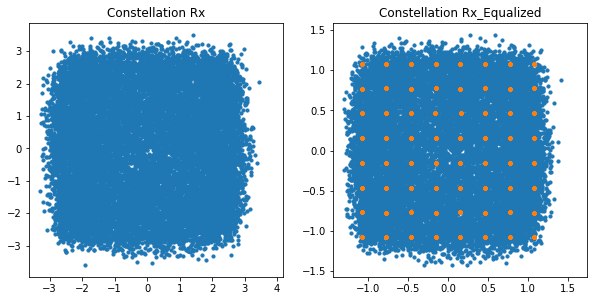

In [38]:
## generate the MB distribution
v=0
c=(-v)*(np.abs(cons_init)**2)
fenzi=np.exp(c)
fenmu=np.sum(fenzi)
P_MB=fenzi/fenmu
P_MB=P_MB
P_MB=P_MB/np.sum(P_MB)
entropy_S_MB = -p_norm(P_MB, P_MB, lambda x: log2(x))
norm_factor_MB = tf.math.rsqrt(tf.maximum(p_norm(P_MB, cons_init),norm_epsilon))
norm_cons_MB = r2c(norm_factor_MB) * cons_init

## Validation
GMI_MonteCarlo = []
for i in range(nBatches):
    Tx_cons_MB = np.array(random.choices(cons_init,weights=P_MB,k=batchSize))
    Tx_cons_MB = r2c(norm_factor_MB) * Tx_cons_MB
    Tx_cons_MB_RRC = upsample_pulse_shaping(Tx_cons_MB, Fs, PS_filter)
    Rx_MB = channel_ISI_NL(Tx_cons_MB_RRC,channel_SNR_db1,channel_FIR,nl_factor=nl_factor,ch_type=channel_type)
    Rx_ME_eq = Model_Eq(Rx_MB[np.newaxis,:])
    
    Tx_label = Tx_cons_MB.numpy().ravel()
    Rx_label = Rx_ME_eq.numpy().ravel()
    
    GMI_MonteCarlo.append(GMIcal(Tx_label,Rx_label,M,norm_cons_MB.numpy(),hard_bits_out,P_MB))

## plot the Equalizer output
y_match_real = np.convolve(Rx_MB, g_cos[::-1,0,0], mode='same')
y_match_imag = np.convolve(Rx_MB, -g_sin[::-1,0,0], mode='same')
# TODO: downsampling method need more consideration
y_match_real_ds = y_match_real[0::Fs]
y_match_imag_ds = y_match_imag[0::Fs]

fig0, ax0 = plt.subplots(1,2)
ax0[0].set_title('Constellation Rx')
ax0[0].scatter(y_match_real_ds,y_match_imag_ds,s=10)
ax0[0].axis('square')

ax0[1].set_title('Constellation Rx_Equalized')
ax0[1].scatter(np.real(Rx_label), np.imag(Rx_label), s=10)
ax0[1].scatter(np.real(Tx_label),np.imag(Tx_label),s=10)
ax0[1].axis('square')
fig0.show();fig0.set_size_inches(10,5)

GMI_MB = np.mean(GMI_MonteCarlo)
NGMI_MB = 1-(entropy_S_MB-GMI_MB)/bitlen
print('[DEBUG] MB_GMI = %.2f, MB_NGMI = %.2f, entropy = %.2f, %d dB SNR'%(GMI_MB,NGMI_MB,entropy_S_MB,channel_SNR_db))

## Define the training step

In [39]:
# %% Initialization on optimizer and checkpoint
optimizer       = tf.optimizers.Adam(learning_rate=learningRate)
checkpoint_dir = './model_free_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 logit_model=logit_model,
                                 Trans_model_bit=Trans_model_bit,
                                 dec_model=dec_model,
                                 soft_bit_decoder=soft_bit_decoder)
manager_Loss = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5, checkpoint_name='V6_ckpt_Loss')
manager_MI = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5, checkpoint_name='V6_ckpt_MI')
tf.config.run_functions_eagerly(False)

# %% Training
## training step
@tf.function
def train_step(inp_SNR,noise,GS_flag,PS_flag,eq_flag,epsilon=1e-12):
    loss = 0
    with tf.GradientTape() as tape:
        # PS and GS mapping
        ## PS
        s_logits = logit_model(inp_SNR)
        
        ## Sampler
        s = s_model(s_logits)
        
        ## GS
        soft_bits = soft_bit_encoder(s)
        hard_bits = hard_decision_on_bit(soft_bits)

        
        ## normalization the constellation
        enc = Trans_model_bit(hard_bits)
        bit_set = tf.math.mod(tf.bitwise.right_shift(tf.expand_dims(symbol_set,1), tf.range(bitlen)), 2)
        bit_set = tf.reverse(bit_set, axis = [-1])
        constellation = Trans_model_bit(bit_set)
        constellation = tf.expand_dims(constellation, 0)
        
        p_s = tf.nn.softmax(s_logits)   # the distribution p(s) can be retrieved by applying a softmax activation to the logits
        # norm_factor = tf.math.rsqrt(p_norm(p_s, constellation))
        norm_factor= tf.math.rsqrt(tf.maximum(p_norm(p_s, constellation),epsilon))
        norm_constellation = r2c(norm_factor) * constellation
        should_always_be_one = p_norm(p_s, norm_constellation)
        
        # Tx Modulation
        x = r2c(norm_factor) * enc
        # x = tf.linalg.matmul(r2c(s),tf.transpose(norm_constellation))   # equivalent to the above line

        # Upsampling and Pulse shaping
        Tx = upsample_pulse_shaping(x, Fs, PS_filter)
        
        # Channel
        Rx = Tx + noise
        
        # equalizer
        y = Model_Eq(Rx)
        
        # demodulator
        
        # Loss and metrics
        entropy_S = -p_norm(p_s, p_s, lambda x: log2(x))
        GMI = GMIcal_tf(x,tf.squeeze(y),M,norm_constellation,hard_bits_out,p_s)
        NGMI = 1-(entropy_S-GMI)/bitlen
        loss_NGMI = tf.nn.relu(NGMI_th-NGMI)
        loss_Eq = tf.reduce_mean(tf.square(tf.abs(x-y)))
        
        loss = loss_Eq*eq_flag*0.5-GMI+loss_NGMI*100
        
        # update the gradients
        variables = (logit_model.trainable_variables * PS_flag + s_model.trainable_variables + Trans_model_bit.trainable_variables*GS_flag 
                     + Model_Eq.trainable_variables*eq_flag)
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        
        # return loss, loss_MI, loss_GMI, should_always_be_one, MI,tf.reduce_mean(entropy_S), norm_constellation, x
        return loss,loss_Eq,NGMI,GMI,tf.reduce_mean(entropy_S),p_s,norm_constellation,x

def get_Tx(inp_SNR,epsilon=1e-12):
    # %% PS and GS mapping
    ## PS
    s_logits = logit_model(inp_SNR)
    
    ## Sampler
    s = s_model(s_logits)
    
    ## GS
    soft_bits = soft_bit_encoder(s)
    hard_bits = hard_decision_on_bit(soft_bits)
    
    # # normalization the constellation
    # xSeed = tf.linalg.eye(constellationOrder, dtype=s.dtype)
    # constellation_vec = GS_model(xSeed)
    # constellation = tf.expand_dims(tf.complex(constellation_vec[:, 0], constellation_vec[:, 1]), 0)

    ## New
    enc = Trans_model_bit(hard_bits)
    bit_set = tf.math.mod(tf.bitwise.right_shift(tf.expand_dims(symbol_set,1), tf.range(bitlen)), 2)
    bit_set = tf.reverse(bit_set, axis = [-1])
    constellation = Trans_model_bit(bit_set)
    constellation = tf.expand_dims(constellation, 0)

    p_s = tf.nn.softmax(s_logits)   # the distribution p(s) can be retrieved by applying a softmax activation to the logits
    norm_factor= tf.math.rsqrt(tf.maximum(p_norm(p_s, constellation),epsilon))
    norm_constellation = r2c(norm_factor) * constellation
    
    # Tx Modulation
    x = r2c(norm_factor) * enc
    
    # Upsampling and Pulse shaping
    Tx = upsample_pulse_shaping(x, Fs, PS_filter)
    
    return x.numpy(),Tx.numpy()

def evaluate(inp_SNR,noise,eq_flag,epsilon=1e-12):
    # PS and GS mapping
    ## PS
    s_logits = logit_model(inp_SNR)
    
    ## Sampler
    s = s_model(s_logits)
    
    ## GS
    soft_bits = soft_bit_encoder(s)
    hard_bits = hard_decision_on_bit(soft_bits)

    
    ## normalization the constellation
    enc = Trans_model_bit(hard_bits)
    bit_set = tf.math.mod(tf.bitwise.right_shift(tf.expand_dims(symbol_set,1), tf.range(bitlen)), 2)
    bit_set = tf.reverse(bit_set, axis = [-1])
    constellation = Trans_model_bit(bit_set)
    constellation = constellation - tf.reduce_mean(constellation)
    constellation = tf.expand_dims(constellation, 0)
    
    p_s = tf.nn.softmax(s_logits)   # the distribution p(s) can be retrieved by applying a softmax activation to the logits
    # norm_factor = tf.math.rsqrt(p_norm(p_s, constellation))
    norm_factor= tf.math.rsqrt(tf.maximum(p_norm(p_s, constellation),epsilon))
    norm_constellation = r2c(norm_factor) * constellation
    should_always_be_one = p_norm(p_s, norm_constellation)
    
    # Tx Modulation
    x = r2c(norm_factor) * enc
    # x = tf.linalg.matmul(r2c(s),tf.transpose(norm_constellation))   # equivalent to the above line

    # Upsampling and Pulse shaping
    Tx = upsample_pulse_shaping(x, Fs, PS_filter)

    # Channel
    Rx = Tx + noise

    # equalizer
    y = Model_Eq(Rx)
    
    # Loss and metrics
    entropy_S = -p_norm(p_s, p_s, lambda x: log2(x))
    GMI = GMIcal_tf(x,tf.squeeze(y),M,norm_constellation,hard_bits_out,p_s)
    NGMI = 1-(entropy_S-GMI)/bitlen
    loss_NGMI = tf.nn.relu(NGMI_th-NGMI)
    loss_Eq = tf.reduce_mean(tf.square(tf.abs(x-y)))
    
    loss = loss_Eq*eq_flag*0.5-GMI+loss_NGMI*100
    
    return loss.numpy(), loss_Eq.numpy(), p_s.numpy(), GMI.numpy(), NGMI.numpy(), entropy_S, norm_constellation.numpy(), x.numpy(), y.numpy()

def model_train(batchsize,channel_SNR,noise_init,nl_factor,eq_flag,epsilon,earlystop_epoch):## start training
    # constellation annimation
    fig1, ax1 = plt.subplots(figsize=(4,5))
    Epoch_list = []
    Loss_list = []
    min_loss = 1e10
    max_GMI = 0
    patience = 0
    # initialize the noise
    noise_exp = noise_init[np.newaxis,:]
    
    GS_flag_len = len(GS_flag)
    iter_per_GS_flag = iterations//GS_flag_len
    GS_flag_index = 0
    GS_flag_now = GS_flag[GS_flag_index]
    PS_flag_now = PS_flag[GS_flag_index]
    
    # create two saving figures
    fig=plt.figure()
    ax_1 = fig.add_subplot(121)
    ax_2 = fig.add_subplot(122,projection='3d')
    
    for epoch in range(iterations):
        total_loss     = 0
        total_loss_Eq  = 0
        GMI_mean       = 0
        NGMI_mean      = 0
        
        if GS_flag_len>1 and (epoch+1)%iter_per_GS_flag == 0 and (GS_flag_index+1)<GS_flag_len:
            GS_flag_index += 1
            GS_flag_now = GS_flag[GS_flag_index]
            PS_flag_now = PS_flag[GS_flag_index]
            if GS_flag_now == 1:
                tf.config.run_functions_eagerly(True)
            else:
                tf.config.run_functions_eagerly(False)
            print('[INFO] GS_flag_now = %d, PS_flag_now = %d'%(GS_flag_now,PS_flag_now))
        
        for batch in range(0,batchsize):
            ## get the channel impairments from the Rx data
            noise_tf = tf.cast(noise_exp, dtype=dtype)
            
            ## apply the channel impairments and train the model
            batch_loss,batch_loss_Eq,NGMI,GMI,entropy_S,p_s,norm_constellation,x = train_step(channel_SNR,noise_tf,GS_flag_now,PS_flag_now,eq_flag,epsilon)
            
            ## save the training data x for transmission
            Tx = get_Tx(channel_SNR,epsilon)[-1]
            
            ## Will be substituted by the real channel impairments in the Experiment
            Rx = channel_ISI_NL(Tx,channel_SNR_db1,channel_FIR,nl_factor=nl_factor,ch_type=channel_type)
            
            ## after the transmission, get the Rx data and new noise
            noise_exp = Rx - Tx
            noise_exp = noise_exp[np.newaxis,:]
            
            ## calculate the loss
            total_loss_Eq  += batch_loss_Eq
            total_loss     += batch_loss
            GMI_mean       += GMI
            NGMI_mean      += NGMI
            
        total_loss     = total_loss / batchsize
        total_loss_Eq  = total_loss_Eq / batchsize
        GMI_mean       = GMI_mean / batchsize
        NGMI_mean      = NGMI_mean/ batchsize
        Epoch_list.append(epoch+1)
        Loss_list.append(total_loss.numpy())
        
        if total_loss < min_loss:
            min_loss = total_loss
            manager_Loss.save(checkpoint_number=epoch+1)
            print('[INFO] New Loss = %.6f, Save new model named ./model_free_training_checkpoints/V6_ckpt_Loss-%d.index'%(min_loss,epoch+1))
        if  GMI_mean > max_GMI:
            patience = 0
            max_GMI = GMI_mean
            manager_MI.save(checkpoint_number=epoch+1)
            print('[INFO] New GMI   = %.6f, NGMI = %.6f, Save new model named ./model_free_training_checkpoints/V6_ckpt_MI-%d.index'%(max_GMI,NGMI_mean,epoch+1))
        else:
            patience += 1
            if patience > earlystop_epoch:
                manager_Loss.save(checkpoint_number=epoch+1)
                print('[INFO] Early stop at epoch %d, loss = %.6f, GMI = %.6f'%(epoch+1,total_loss,GMI_mean))
                break
        if (epoch+1)%displayStep == 0 or epoch == 0:
            # np.savetxt('training_data_Tx.txt',Tx,fmt='%f')
            ## draw constellation
            X = np.real(norm_constellation)
            Y = np.imag(norm_constellation)
            ax1.scatter(X,Y,c=cons_colors)
            ax1.axis('square')
            ax1.set_title('Constellation Optimization')
            fig1.canvas.draw()
            fig1.canvas.flush_events()
            print('[DEBUG] epoch:{:3d}/{:2d} | loss: {:.2f} | loss_Eq: {:.4f} | GMI: {:.4f} | NGMI: {:.4f} | entropy_S: {:.4f}'
                .format(epoch+1, iterations, total_loss.numpy(), total_loss_Eq.numpy(), GMI_mean.numpy(), NGMI.numpy(),entropy_S))
            
            ## plot the distribution of PS and GS
            X, Y=X.ravel(), Y.ravel()
            bottom=np.zeros_like(X)
            P=p_s.numpy().ravel()

            ## specific the colormap
            width=height=2/np.sqrt(M+5)
            dz = P
            offset = dz + np.abs(dz.min())
            fracs = offset.astype(float)/offset.max()
            norm = colors.Normalize(fracs.min(), fracs.max())
            color_values = plt.cm.viridis(norm(fracs.tolist()))

            ## draw
            ax_1.cla()
            ax_1.set_title('Constellation Tx')
            ax_1.scatter(X,Y,s=80)
            ax_1.axis('square')
            
            ax_2.cla()
            ax_2.bar3d(X, Y, bottom, width, height, P, shade=True, color=color_values,edgecolor='black')#
            ax_2.set_xlabel('X')
            ax_2.set_ylabel('Y')
            ax_2.set_zlabel('Z(value)')
            # ax_2.set_title('GMI = %.2f, NGMI = %.2f'%(GMI_mean.numpy(),NGMI_mean.numpy()))
            fig.set_size_inches(20,10)
            plt.savefig('./figures/PS_distribution_epoch%d.png'%(epoch+1),dpi=300)
            manager_Loss.save(checkpoint_number=epoch+1)
    
    Epoch_list = np.reshape(np.stack(Epoch_list),-1)
    Loss_list = np.reshape(np.stack(Loss_list),-1)
            
    return Epoch_list,Loss_list

## Model-free procedure

- first use *get_Tx* function to get the *Tx*, the *Tx* is the encoded signal of the next step
- then transmit the *Tx* in the real channel
- get the *Rx_hat* from the real channel
- calculate the *noise = Rx_hat - Tx*
- add the noise into the *train_step* function


## First sent to the real channel

In [40]:
## save file for the first transmission
x,Tx = get_Tx(channel_SNR_db1,epsilon=norm_epsilon)


## Will be substitude by the real channel impairments in the EXPERIMENT
### apply FIR on the Tx data
Rx = channel_ISI_NL(Tx,channel_SNR_db1,channel_FIR,nl_factor=nl_factor,ch_type=channel_type)
y = Model_Eq(Rx[np.newaxis,:])

## Start Training

[INFO] Channel Configuration:
channel_type = ISI_NL

[INFO] Parameter Configuration:
Eq_retrain = 0
nl_factor = 0.500000
norm_epsilon = 1.000000e-12
eq_flag = 1
SNR_dB = 10
eq_flag =  1 
GS_flag =  (1, 1, 1) 
PS_flag =  (1, 1, 1)
[INFO] New Loss = -2.824904, Save new model named ./model_free_training_checkpoints/V6_ckpt_Loss-1.index
[INFO] New GMI   = 3.770306, NGMI = 0.850739, Save new model named ./model_free_training_checkpoints/V6_ckpt_MI-1.index
[DEBUG] epoch:  1/200 | loss: -2.82 | loss_Eq: 0.0385 | GMI: 3.7703 | NGMI: 0.8587 | entropy_S: 4.6731
[INFO] New Loss = -3.748850, Save new model named ./model_free_training_checkpoints/V6_ckpt_Loss-2.index
[INFO] New GMI   = 3.840492, NGMI = 0.860432, Save new model named ./model_free_training_checkpoints/V6_ckpt_MI-2.index
[INFO] New Loss = -3.830459, Save new model named ./model_free_training_checkpoints/V6_ckpt_Loss-3.index
[INFO] New GMI   = 3.859379, NGMI = 0.862037, Save new model named ./model_free_training_checkpoints/V6_ckpt_MI-

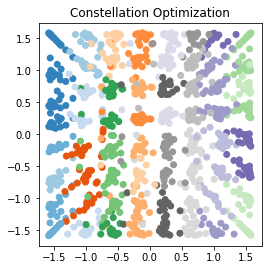

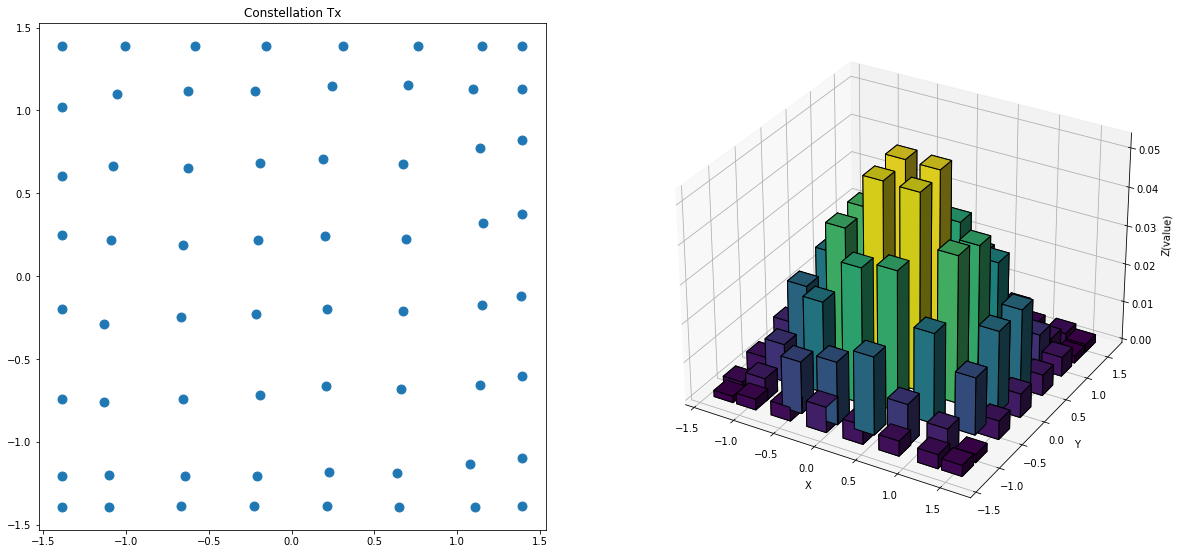

In [41]:
print('[INFO] Channel Configuration:\nchannel_type = %s\n'%(channel_type))
print('[INFO] Parameter Configuration:\nEq_retrain = %d\nnl_factor = %f\nnorm_epsilon = %e\neq_flag = %d\nSNR_dB = %d'%(Eq_retrain,nl_factor,norm_epsilon,eq_flag,channel_SNR_db))
print('eq_flag = ',eq_flag,'\nGS_flag = ',GS_flag,'\nPS_flag = ',PS_flag)
earlystop_epoch = 60
noise_init = Rx.ravel()-Tx
batchsize = 8
## Training
Epoch_list,Loss_list = model_train(batchsize,channel_SNR_db1,noise_init,nl_factor,eq_flag,norm_epsilon,earlystop_epoch)  # alpha = 1, train to maximize MI; alpha = 0, train to maximize GMI

## Validation

Restored from ./model_free_training_checkpoints\V6_ckpt_MI-135
[DEBUG] Train over! val_loss: -4.67,  val_loss_Eq: 0.0374,  GMI: 4.69, NGMI: 0.8621 ,  entropy_S: 5.52,  SNR: 10dB


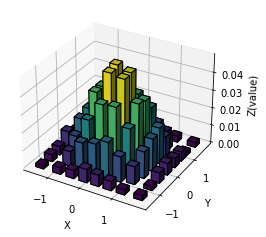

In [42]:
if manager_MI.latest_checkpoint:
    checkpoint_path = manager_MI.latest_checkpoint
    # checkpoint_path = './model_free_training_checkpoints/V6_ckpt_MI-267.index'
    checkpoint.restore(checkpoint_path).expect_partial()
    print("Restored from {}".format(manager_MI.latest_checkpoint))
else:
    print("Load the final trained model")

## after the training, transmit the Tx and get the Rx data and new impairements(noise)
x,Tx = get_Tx(channel_SNR_db1,epsilon=norm_epsilon)
# np.savetxt('training_data_Tx.txt',Tx,fmt='%f')
Rx = channel_ISI_NL(Tx,channel_SNR_db1,channel_FIR,nl_factor=nl_factor,ch_type=channel_type)
# np.savetxt('training_data_Rx.txt',Rx,fmt='%f')
# Rx = np.loadtxt('training_data_Rx.txt',dtype=np.complex)
noise_exp = Rx - Tx
noise_exp = noise_exp[np.newaxis,:]
# noise_exp = tf.cast(noise_exp, dtype=cpx_dtype)


## Validation
loss,loss_Eq,p_s,GMI,NGMI,entropy_S,norm_constellation, x, y = evaluate(channel_SNR_db1,noise_exp,eq_flag,epsilon=norm_epsilon)
print('[DEBUG] Train over! val_loss: {:.3},  val_loss_Eq: {:.3},  GMI: {:.3}, NGMI: {:.4} ,  entropy_S: {:.3},  SNR:{:3d}dB'
          .format(loss,loss_Eq,GMI,NGMI,entropy_S,channel_SNR_db))

## plot the distribution of PS and GS
X = np.real(norm_constellation)
Y = np.imag(norm_constellation)
X, Y=X.ravel(), Y.ravel()
bottom=np.zeros_like(X)
P=p_s.ravel()

# draw the PS map
## specific the colormap
width=height=0.25
dz = P
offset = dz + np.abs(dz.min())
fracs = offset.astype(float)/offset.max()
norm = colors.Normalize(fracs.min(), fracs.max())
color_values = plt.cm.viridis(norm(fracs.tolist()))
# color_values = plt.cm.get_cmap('tab20c', 64).colors
## draw
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
ax.bar3d(X, Y, bottom, width, height, P, shade=True, color=color_values,edgecolor='black')#
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z(value)')
plt.show()

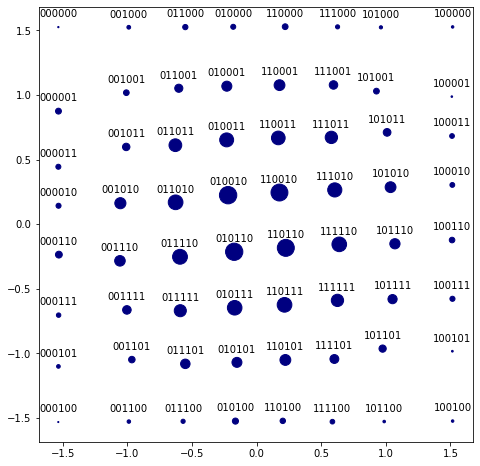

In [43]:
np_x = []
np_y = []
for _ in range(20):
    gumble_samples = g_dist.sample(sample_shape=[batchSize, M])
    x,Tx = get_Tx(channel_SNR_db1,epsilon=norm_epsilon)
    Rx = channel_ISI_NL(Tx,channel_SNR_db1,channel_FIR,nl_factor=nl_factor,ch_type=channel_type)

    noise_exp = Rx - Tx
    noise_exp = noise_exp[np.newaxis,:]
    temp_x, temp_y  = evaluate(channel_SNR_db1,noise_exp,eq_flag)[-2: ]
    np_x.append(temp_x)
    np_y.append(temp_y)
    
all_y = np.reshape(np.stack(np_y),-1)
all_x = np.reshape(np.stack(np_x),-1)

norm_constellation_real = np.real(norm_constellation).ravel()
norm_constellation_imag = np.imag(norm_constellation).ravel()

# Create the scatter plot
fig3, ax3 = plt.subplots()
cmap = plt.get_cmap('Purples')
# plt.figure(figsize=(8,8))
cons_size = (P-np.min(P)+np.min(P)/10)/(np.max(P)-np.min(P))*300
ax3.scatter(norm_constellation_real, norm_constellation_imag, c='navy', s=cons_size)
ax3.axis('square');
fig3.set_size_inches(8,8)
# Add labels around the scatter points
for i, label in enumerate(hard_bits_out):
    label = ''.join([str(int(x-1+1)) for x in label])
    ax3.annotate(label, (norm_constellation_real[i], norm_constellation_imag[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize = 10)

## Eq output and GMI

[DEBUG] GMI = 4.6889, NGMI = 0.8621, entropy_S = 5.5163


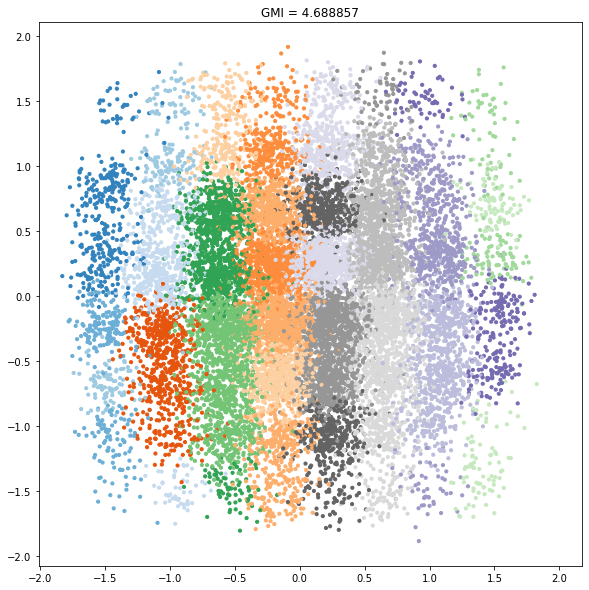

In [44]:
all_x_integer = np.argmin(np.abs(all_x[0:batchSize,np.newaxis] - norm_constellation), axis=1)
all_x_color   = np.array(cons_colors)[all_x_integer]
all_y_real = np.real(all_y[0:batchSize]).ravel()
all_y_imag = np.imag(all_y[0:batchSize]).ravel()

fig5, ax5 = plt.subplots()
ax5.scatter(all_y_real, all_y_imag, c=all_x_color, s=10)
ax5.axis('square');
fig5.set_size_inches(10,10)

x_in = all_x[0:65536]
y_in = all_y[0:65536]
avp = np.sqrt(np.mean(np.abs(x_in)**2))
y_in = y_in/np.sqrt(np.mean(np.abs(y_in)**2))*avp
print('[DEBUG] GMI = %.4f, NGMI = %.4f, entropy_S = %.4f'%(GMI,NGMI,entropy_S))
ax5.title.set_text('GMI = '+str(GMI))